# Neural network classification with Pytorch

Book version of this notebook: https://www.learnpytorch.io/02_pytorch_classification/

## 1. Make classification data and get it ready

In [82]:
from sklearn.datasets import make_circles, make_blobs
import pandas as pd
import matplotlib.pyplot as plt
import torch
from sklearn.model_selection import train_test_split
from torch import nn
import requests
from pathlib import Path
from torchmetrics import Accuracy

In [2]:
# Make 1000 samples
n_samples = 1000

# Create circles
X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42)


In [3]:
len(X), len(y)

(1000, 1000)

In [4]:
print(f"First 5 samples of X:\n{X[:5]}")
print(f"First 5 samples of y:\n{y[:5]}")

First 5 samples of X:
[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
First 5 samples of y:
[1 1 1 1 0]


In [5]:
# Make dataframe of circle data
circles = pd.DataFrame({"X1": X[:, 0],
                        "X2": X[:, 1],
                        "label": y})
print(circles)

           X1        X2  label
0    0.754246  0.231481      1
1   -0.756159  0.153259      1
2   -0.815392  0.173282      1
3   -0.393731  0.692883      1
4    0.442208 -0.896723      0
..        ...       ...    ...
995  0.244054  0.944125      0
996 -0.978655 -0.272373      0
997 -0.136900 -0.810012      1
998  0.670362 -0.767502      0
999  0.281057  0.963824      0

[1000 rows x 3 columns]


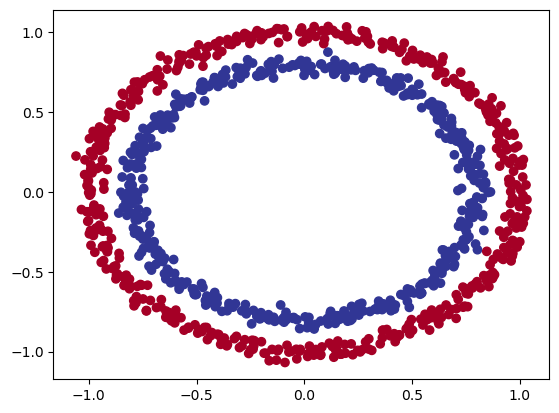

In [6]:
# Visualize, visualize, visualize
plt.scatter(X[:, 0],
            X[:, 1],
            c=y,
            cmap=plt.cm.RdYlBu)
plt.show()

Note : The data we are working with is often refered to a toy dataset, 
a dataset that is small enough to experiment but still sizeable enough to practice the fundamentals.

### 1.1 Check input and output shapes

In [7]:
# View the first example of features and labels
X_sample = X[0]
y_sample = y[0]

print(f"Values for one sample of X: {X_sample} and the same for y: {y_sample}")
print(f"Shapes for one sample of X: {X_sample.shape} and the same for y: {y_sample.shape}")

Values for one sample of X: [0.75424625 0.23148074] and the same for y: 1
Shapes for one sample of X: (2,) and the same for y: ()


### 1.2 Turn data into tensors and create train/test splits


In [8]:
# Turn data into tensors
X = torch.from_numpy(X).type(torch.float) # convert from float64 to float32 tensor
y = torch.from_numpy(y).type(torch.float) 

X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [9]:
X.dtype, y.dtype

(torch.float32, torch.float32)

In [10]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

In [11]:
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

## 2. Build the model

To do so, we want to:
1. Setup device agonistic code so  our code will onto the GPU
2. Construct a model (by subclassing `nn.Module`)
3. Define loss function and optimizer
4. Create a training loop and a test loop

In [12]:
# Create device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cpu


Let's create a model that:

1. Subclasses `nn.Module`
2. Create 2 `nn.Linear()` layers that are capable of handling the shape of our data.
3. Define a forward method that returns the output of the forward pass (or forward computation) of the model.
4. Instentiate an instance of our model class and send it to the target `device`.

In [13]:
# 1. Construct a model class that subclasses nn.Module
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        # 2. Create 2 nn.Linear layers capable of handling X and y input and output shapes
        self.layer_1 = nn.Linear(in_features=2, out_features=8)
        self.layer_2 = nn.Linear(in_features=8, out_features=1)
    
        # self.two_linear_layers = nn.Sequential(
        #     nn.Linear(in_features=2, out_features=8),
        #     nn.Linear(in_features=8, out_features=1)
        # )
    # 3. Define a forward() method that outlines the forward pass
    def forward(self, x): # <- define the forward pass
        return self.layer_2(self.layer_1(x))
        # return self.two_linear_layers(x)

In [14]:
# 4. Create an instance of the model and send it to the target device
model_0 = CircleModelV0().to(device)
print(model_0)

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=8, bias=True)
  (layer_2): Linear(in_features=8, out_features=1, bias=True)
)


In [15]:
next(model_0.parameters()).device

device(type='cpu')

In [16]:
# Let's replicate the model above using nn.Sequential()
# model_0 = nn.Sequential(
#     nn.Linear(in_features=2, out_features=8),
#     nn.Linear(in_features=8, out_features=1)
# ).to(device)

model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=8, bias=True)
  (layer_2): Linear(in_features=8, out_features=1, bias=True)
)

In [17]:
model_0.state_dict() # number of weights fit the number of branchs and the number of biais fit the number of neurons

OrderedDict([('layer_1.weight',
              tensor([[ 0.3795, -0.1067],
                      [-0.3734, -0.6404],
                      [-0.6692,  0.6668],
                      [ 0.2446,  0.4170],
                      [ 0.0755,  0.4759],
                      [-0.1233, -0.6188],
                      [-0.4303, -0.3830],
                      [-0.6171, -0.3754]])),
             ('layer_1.bias',
              tensor([ 0.0980,  0.5915, -0.0138, -0.2135, -0.2801, -0.6538, -0.6733,  0.1192])),
             ('layer_2.weight',
              tensor([[-0.0365,  0.2673, -0.2957, -0.0157,  0.0300,  0.3438,  0.0962, -0.0110]])),
             ('layer_2.bias', tensor([-0.1881]))])

In [18]:
# Make predictions with model
with torch.inference_mode():
    untrained_preds = model_0(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(X_test)}, Shape: {X_test.shape}")
print(f"\nFirst 10 predictions:\n{torch.round(untrained_preds[:10])}")
print(f"\nFirst 10 test labels:\n{y_test[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200, 2])

First 10 predictions:
tensor([[-1.],
        [-1.],
        [-0.],
        [-1.],
        [ 0.],
        [ 0.],
        [-1.],
        [-0.],
        [-0.],
        [-1.]])

First 10 test labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


### Set up the loss function and optimizer

Which loss function or optimizer should we use for our model?
    
For regression you might want MAE or MSE
For classification you might want Binary Cross Entropy or Categorical Cross Entropy

And for optimization you might want Adam or SGD, however Pytorch has many built-in functions.
    
* For common choices of losses functions and optimizers: https://www.learnpytorch.io/02_pytorch_classification/#21-setup-loss-function-and-optimizer    
* For the loss function we use `torch.nn.BCEWithLogitsLoss`, for more on what binary cross entropy is check out this article: https://towardsdatascience.com/understanding-binary-cross-entropy-log-loss-a-visual-explanation-a3ac6025181a
* For a definition of what a logit is check out this article: https://stackoverflow.com/questions/41455101/what-is-the-meaning-of-the-word-logits-in-tensorflow
* For different optimizers see: https://pytorch.org/docs/stable/optim.html

In [19]:
# Setup the loss function
# loss_fn = nn.BCELoss() # BCELoss = requires to have gone through the sigmoid activation function in the model first
# nn.Sequential(
#     nn.Sigmoid(),
#     nn.BCELoss()
# )
loss_fn = nn.BCEWithLogitsLoss() # BCEWithLogitsLoss = sigmoid activation function + BCE
optimizer = torch.optim.SGD(params=model_0.parameters(),
                             lr=0.1)

In [20]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100 
    return acc

## 3. Train the model

To train the model, we're going to need to build a training loop:

1. Forward pass
2. Calculate the loss
3. optimizer zero grad
4. loss backward (backpropagation)
5. optimizer (gradient descent)

### 3.1 Going from raw logits -> prediction probabilities -> predictions labels

Our model outputs are going to be raw **logits**. 
We need to turn these **logits** into **prediction probabilities** by applying the activation function (sigmoid for binary classification and softmax for multiclass classification).

Then we need to turn these **prediction probabilities** into **predictions labels** by either rounding them or getting the index with the maximum value (`torch.argmax()`).

In [21]:
# View the first 5 outputs of the forward pass on the test data
with torch.inference_mode():
    y_logits = model_0(X_test.to(device))[:5]
print(f"Logits: {y_logits}")

Logits: tensor([[-0.7386],
        [-0.9034],
        [-0.1399],
        [-0.9090],
        [ 0.1247]])


In [22]:
# Use the sigmoid activation function to get the prediction probabilities 
y_pred_probs = torch.sigmoid(y_logits)
print(f"Pred probs: {y_pred_probs}")

Pred probs: tensor([[0.3233],
        [0.2883],
        [0.4651],
        [0.2872],
        [0.5311]])


For our prediction probability values, we need to perform a range-style rounding on them:
* `y_preds_probs` >= 0.5, `y =1` (class 1)
* `y_preds_probs` < 0.5, `y =0` (class 0)

In [23]:
# Find the predicted labels (round the prediction probabilities)
y_preds = torch.round(y_pred_probs)

# In full
y_preds_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

# Check for equality
print(torch.eq(y_preds.squeeze(), y_preds_labels.squeeze()))

# Get rid of extra dimensions
y_preds.squeeze()

tensor([True, True, True, True, True])


tensor([0., 0., 0., 0., 1.])

### 3.2 Building a training and testing loop


In [24]:
def train_test_loop(epochs: int,
                    loss_fn: torch.nn.Module,
                    optimizer: torch.optim.Optimizer,    
                    model: torch.nn.Module,
                    accuracy_fn=None,
                    device: torch.device = device,
                    X_train: torch.Tensor = X_train,
                    y_train: torch.Tensor = y_train,
                    X_test: torch.Tensor = X_test,
                    y_test: torch.Tensor = y_test,
                    epoch_display_frequency=10,
                    multiclass=False):
    """Trains and test a PyTorch model."""
    torch.manual_seed(42)
    torch.cuda.manual_seed(42)

    # Put data to target device
    X_train, y_train = X_train.to(device), y_train.to(device)
    X_test, y_test = X_test.to(device), y_test.to(device)

    # Build training and evaluation loop
    for epoch in range(epochs):
        ### TRAINING
        model.train() # train mode is on by default after construction

        # 1. Forward pass
        if accuracy_fn is not None and multiclass is False:
            y_logits = model(X_train).squeeze()
            y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> prediction probabilities -> prediction labels
        elif multiclass:
            y_logits = model(X_train.to(torch.float32))
            y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)
        else:
            y_pred = model(X_train)

        # 2. Calculate loss and accuracy
        if accuracy_fn is None:
            loss = loss_fn(y_pred, y_train)
        else:
            loss = loss_fn(y_logits,
                           y_train) 
            acc = accuracy_fn(y_true=y_train,
                              y_pred=y_pred)
        
        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step (gradient descent)
        optimizer.step()

        ### TESTING
        model.eval() # put the model in evaluation mode
        with torch.inference_mode():
            # 1. Forward pass
            if accuracy_fn is not None and multiclass is False:
                test_logits = model(X_test).squeeze()
                test_pred = torch.round(torch.sigmoid(test_logits))
            elif multiclass:
                test_logits = model(X_test.to(torch.float32))
                test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
            else:
                test_pred = model(X_test)

            # 2. Caculate loss and accuracy
            if accuracy_fn is None:
                test_loss = loss_fn(test_pred, y_test)
            else:
                test_loss = loss_fn(test_logits,
                                    y_test)
                test_acc = accuracy_fn(y_true=y_test,
                                    y_pred=test_pred)

            # Print out what's happening
            if epoch % epoch_display_frequency == 0:
                if accuracy_fn is None:
                    print(f"Epoch: {epoch} | Loss: {loss:.5f} | Test loss: {test_loss:.5f}")
                else:
                    print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

In [25]:
train_test_loop(epochs=100, model=model_0, loss_fn=loss_fn, optimizer=optimizer, accuracy_fn=accuracy_fn)

Epoch: 0 | Loss: 0.72667, Accuracy: 46.88% | Test loss: 0.71253, Test acc: 49.00%
Epoch: 10 | Loss: 0.71070, Accuracy: 47.62% | Test loss: 0.69928, Test acc: 50.50%
Epoch: 20 | Loss: 0.70361, Accuracy: 47.88% | Test loss: 0.69446, Test acc: 51.00%
Epoch: 30 | Loss: 0.69986, Accuracy: 48.62% | Test loss: 0.69264, Test acc: 52.50%
Epoch: 40 | Loss: 0.69761, Accuracy: 49.00% | Test loss: 0.69202, Test acc: 52.00%
Epoch: 50 | Loss: 0.69617, Accuracy: 48.75% | Test loss: 0.69193, Test acc: 51.00%
Epoch: 60 | Loss: 0.69521, Accuracy: 49.50% | Test loss: 0.69207, Test acc: 49.50%
Epoch: 70 | Loss: 0.69456, Accuracy: 49.25% | Test loss: 0.69232, Test acc: 49.50%
Epoch: 80 | Loss: 0.69411, Accuracy: 49.50% | Test loss: 0.69260, Test acc: 50.00%
Epoch: 90 | Loss: 0.69379, Accuracy: 50.38% | Test loss: 0.69288, Test acc: 49.00%


## 4. Make predictions and evaluate the model
From the metrics, it look like the model is not learning anything.

So to inspect it let's make some predictions and make them visual!

In other words, visualize, visualize, visualize!

To do so, we're going to import a function called `plot_decision_boundary()` - https://github.com/JoachimLombardi/Helper_functions/blob/master/course_ztm.py

In [26]:
# Download the helper function
if Path("course_ztm.py").is_file():
    print("course_ztm.py already exists, skipping download")
else:
    print("Downloading course_ztm.py")
    request = requests.get("https://raw.githubusercontent.com/JoachimLombardi/Helper_functions/master/course_ztm.py")
    with open("helper_functions.py", "wb") as f:
        f.write(request.content)

In [27]:
from helper_functions import plot_predictions, plot_decision_boundary

In [79]:
def plot_train_test_decision_boundary(model:torch.nn.Module, X_train:torch.Tensor=X_train, y_train:torch.Tensor=y_train, X_test:torch.Tensor=X_test, y_test:torch.Tensor=y_test):
    # Plot decision boundaries for training and test sets
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.title("Train")
    plot_decision_boundary(model, X_train, y_train)
    plt.subplot(1, 2, 2)
    plt.title("Test")
    plot_decision_boundary(model, X_test, y_test)

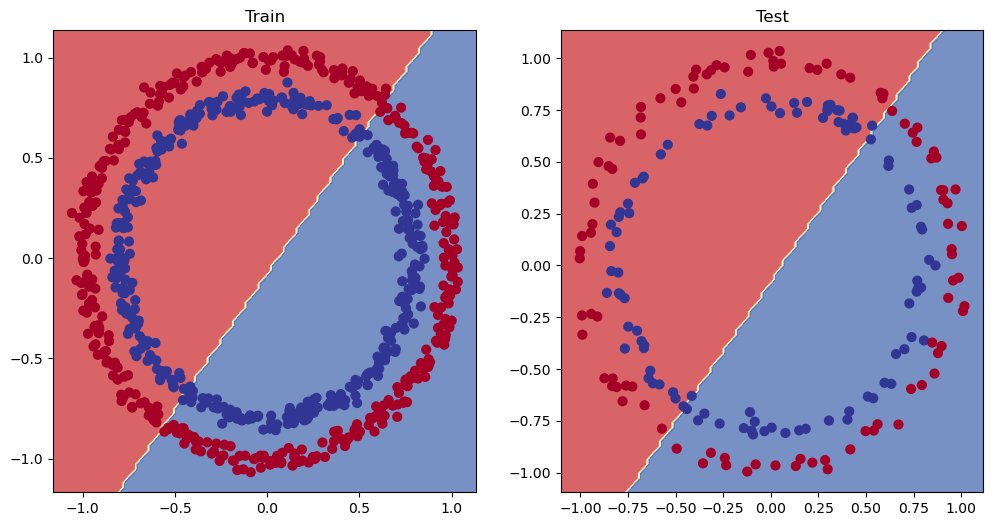

In [29]:
plot_train_test_decision_boundary(model_0)

## 5. Improving a model (from a model perspective)

* Add more layers - Give the model more chances to learn about patterns in the data.
* Add more hidden units - Increase the number of neurons in the model from 5 to 10.
* Increase the number of epochs - Increase the number of times the model will see the data. 
* Change the activation function.
* Change the optimizer - Change the optimizer from SGD to Adam.
* Increase the learning rate.
* Change the loss function.

These options are all from the model's perspective because they deal directly with the model, rather than the data.

And because this options are all values we (as machine learning engineers and data scientists) can adjust, they are often referred to as **hyperparameters**.

Let's try and improve our model by:
* Adding more hidden units: 8 -> 10
* Increase the number of layers: 2 -> 3
* Increase the number of epochs: 100 -> 1000

In [30]:
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)

    def forward(self, x):
        #  z = self.layer_1(x)
        #  z = self.layer_2(z)
        #  z = self.layer_3(z)
         return self.layer_3(self.layer_2(self.layer_1(x))) # this way of writing operations leverages speed ups where possible behind the scenes


In [31]:
model_1 = CircleModelV1().to(device)
print(model_1)

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)


In [32]:
optimizer_model_1 = torch.optim.SGD(params=model_1.parameters(), lr=0.1)

In [33]:
train_test_loop(epochs=1000,
                model=model_1,
                loss_fn=loss_fn,
                optimizer=optimizer_model_1,
                accuracy_fn=accuracy_fn,
                epoch_display_frequency=100)

Epoch: 0 | Loss: 0.69396, Accuracy: 50.88% | Test loss: 0.69261, Test acc: 51.00%
Epoch: 100 | Loss: 0.69305, Accuracy: 50.38% | Test loss: 0.69379, Test acc: 48.00%
Epoch: 200 | Loss: 0.69299, Accuracy: 51.12% | Test loss: 0.69437, Test acc: 46.00%
Epoch: 300 | Loss: 0.69298, Accuracy: 51.62% | Test loss: 0.69458, Test acc: 45.00%
Epoch: 400 | Loss: 0.69298, Accuracy: 51.12% | Test loss: 0.69465, Test acc: 46.00%
Epoch: 500 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69467, Test acc: 46.00%
Epoch: 600 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 700 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 800 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 900 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69468, Test acc: 46.00%


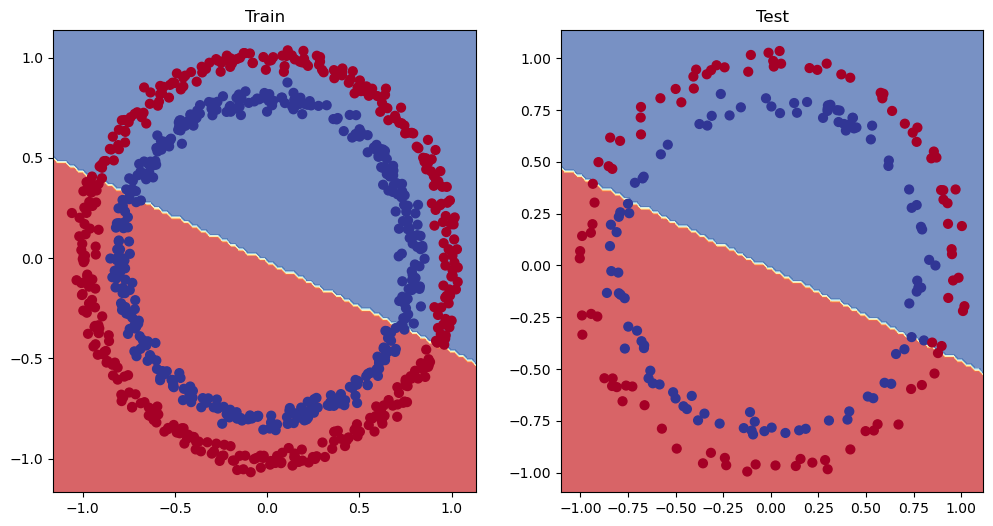

In [34]:
plot_train_test_decision_boundary(model_1)

### 5.1 Preparing data to see if our model can fit a straight line


In [35]:
# Create some data
weight = 0.7
bias = 0.3
start = 0
end = 1
step = 0.01
X_regression = torch.arange(start, end, step).unsqueeze(dim=1)
y_regression = weight * X_regression + bias

# Check the data
print(len(X_regression))
print(len(y_regression))
print(X_regression[:5])
print(y_regression[:5])

100
100
tensor([[0.0000],
        [0.0100],
        [0.0200],
        [0.0300],
        [0.0400]])
tensor([[0.3000],
        [0.3070],
        [0.3140],
        [0.3210],
        [0.3280]])


In [36]:
# Create training and test splits
train_split = int(0.8 * len(X_regression))
X_train_regression, y_train_regression = X_regression[:train_split], y_regression[:train_split]
X_test_regression, y_test_regression = X_regression[train_split:], y_regression[train_split:]
print(len(X_train_regression), len(y_train_regression))
print(len(X_test_regression), len(y_test_regression))

80 80
20 20


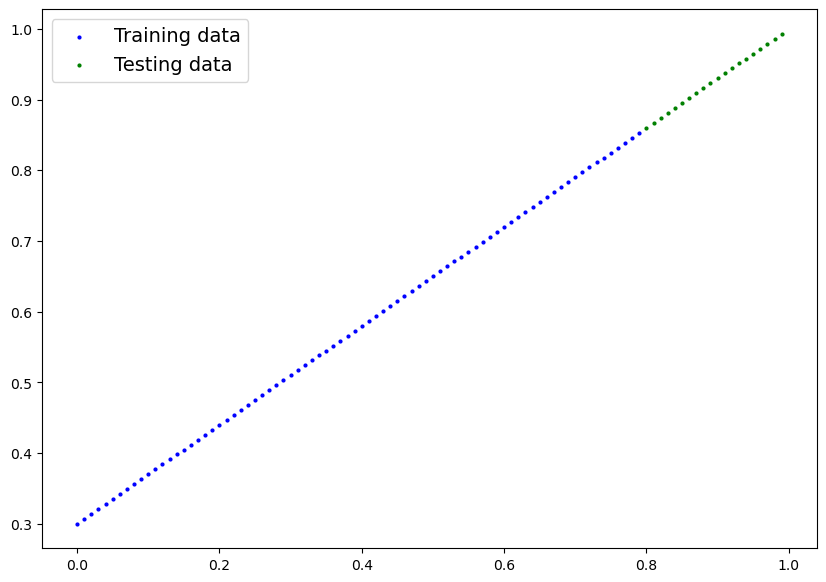

In [37]:
plot_predictions(X_train_regression,
                 y_train_regression,
                 X_test_regression,
                 y_test_regression)

### 5.2 Adjusting `model_1` to fit a straight line

In [38]:
# Same architecture as model_1 (but using nn.Sequential())
model_2 = nn.Sequential(
    nn.Linear(in_features=1, out_features=10),
    nn.Linear(in_features=10, out_features=10),
    nn.Linear(in_features=10, out_features=1)
).to(device)

print(model_2)

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)


In [39]:
# Loss and optimizer
loss_fn_regression = nn.L1Loss()
optimizer_regression = torch.optim.SGD(model_2.parameters(), lr=0.01)

In [40]:
train_test_loop(epochs=1000,
                model=model_2,
                loss_fn=loss_fn_regression, 
                optimizer=optimizer_regression, 
                X_train=X_train_regression, 
                y_train=y_train_regression, 
                X_test=X_test_regression, 
                y_test=y_test_regression,
                epoch_display_frequency=100)

Epoch: 0 | Loss: 0.75986 | Test loss: 0.91103
Epoch: 100 | Loss: 0.02858 | Test loss: 0.00081
Epoch: 200 | Loss: 0.02533 | Test loss: 0.00209
Epoch: 300 | Loss: 0.02137 | Test loss: 0.00305
Epoch: 400 | Loss: 0.01964 | Test loss: 0.00341
Epoch: 500 | Loss: 0.01940 | Test loss: 0.00387
Epoch: 600 | Loss: 0.01903 | Test loss: 0.00379
Epoch: 700 | Loss: 0.01878 | Test loss: 0.00381
Epoch: 800 | Loss: 0.01840 | Test loss: 0.00329
Epoch: 900 | Loss: 0.01798 | Test loss: 0.00360


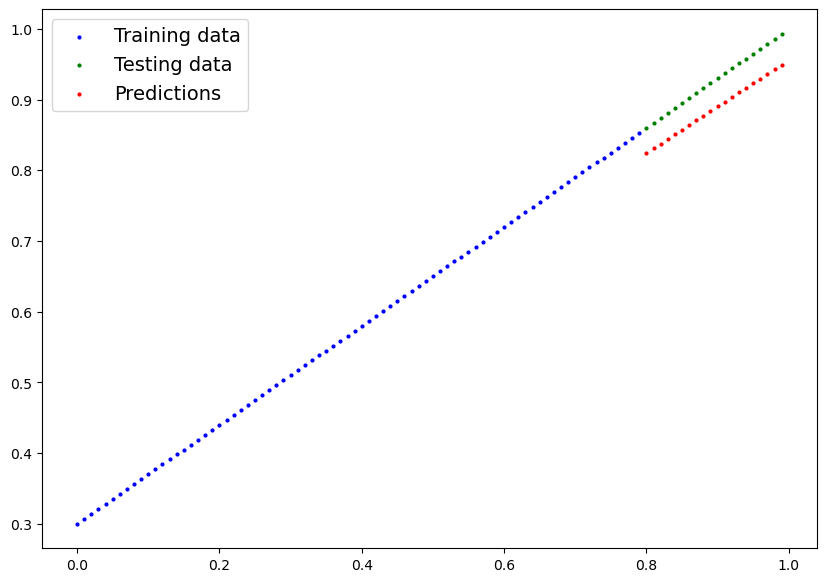

In [41]:
# Turn on the inference mode
model_2.eval()

# Make predictions (inference)
with torch.inference_mode():
    y_preds = model_2(X_test_regression)
plot_predictions(X_train_regression, 
                 y_train_regression, 
                 X_test_regression, 
                 y_test_regression, 
                 predictions=y_preds)

## 6. The missing piece: non-linearity

" What patterns could you draw if you were given an infinite amount of straight and non-straight lines?"

Or in machine learning terms, an infinite (but really it is finite) of linear and non-linear functions?

### 6.1 Building a model with non-linearity

In [42]:
# Build a model with non-linear activation functions
class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=128)
        self.layer_2 = nn.Linear(in_features=128, out_features=128)
        self.layer_3 = nn.Linear(in_features=128, out_features=1)
        self.relu = nn.ReLU() # <- add in ReLU activation function

    def forward(self, x):
        # z = self.layer_1(x)
        # z = self.relu(z)
        # z = self.layer_2(z)
        # z = self.relu(z)
        # z = self.layer_3(z)
        return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x))))) # this way of writing operations leverages speed ups where possible behind the scenes

In [43]:
model_3 = CircleModelV2().to(device)
print(model_3)

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=128, bias=True)
  (layer_2): Linear(in_features=128, out_features=128, bias=True)
  (layer_3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)


In [44]:
# Loss and optimizer
loss_fn_classification = nn.BCEWithLogitsLoss()
optimizer_model_3 = torch.optim.SGD(model_3.parameters(), lr=0.1)

### 6.3 Training a model with non-linearity

In [45]:
# Training loop
train_test_loop(epochs=501, 
                loss_fn=loss_fn_classification, 
                model=model_3,
                optimizer=optimizer_model_3, 
                accuracy_fn=accuracy_fn, 
                X_train=X_train, 
                y_train=y_train, 
                X_test=X_test, 
                y_test=y_test, 
                epoch_display_frequency=100) 

Epoch: 0 | Loss: 0.69356, Accuracy: 50.00% | Test loss: 0.69433, Test acc: 50.00%
Epoch: 100 | Loss: 0.66885, Accuracy: 79.38% | Test loss: 0.67405, Test acc: 79.00%
Epoch: 200 | Loss: 0.61478, Accuracy: 97.12% | Test loss: 0.62874, Test acc: 91.50%
Epoch: 300 | Loss: 0.48201, Accuracy: 99.00% | Test loss: 0.51379, Test acc: 98.00%
Epoch: 400 | Loss: 0.28199, Accuracy: 99.62% | Test loss: 0.32896, Test acc: 99.00%
Epoch: 500 | Loss: 0.15238, Accuracy: 100.00% | Test loss: 0.19601, Test acc: 100.00%


### 6.4 Evaluating a model trained with non-linear activation function

In [46]:
# Make predictions
with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(model_3(X_test))).squeeze()
y_preds[:10], y_test[:10] # want preds in same format as truth labels

(tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]))

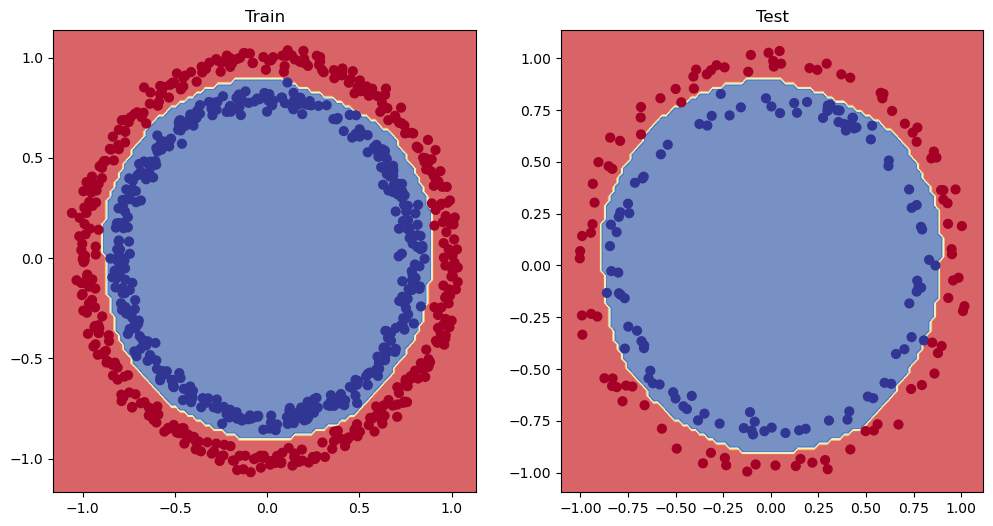

In [47]:
# Plot decision boundaries
plot_train_test_decision_boundary(model_3)

## 7. Replicating non-linear activation functions

Neural networks, rather than us telling the model what to learn, we give it the tools to discover patterns in data and it tries to figure out what those patterns on its own.

And this tools are linear and non-linear functions.

In [48]:
# Create a tensor
A = torch.arange(-10, 10, 1.0)
A.dtype

torch.float32

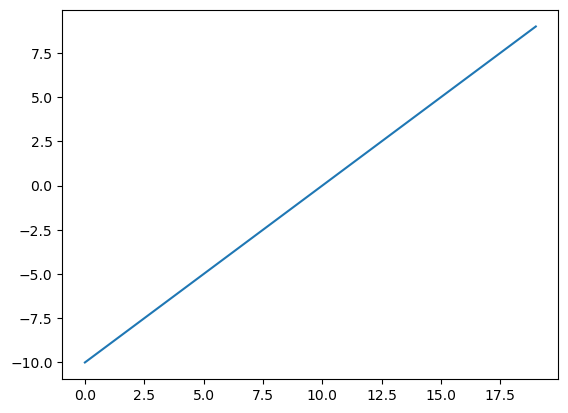

In [49]:
# Visualize the tensor
plt.plot(A);

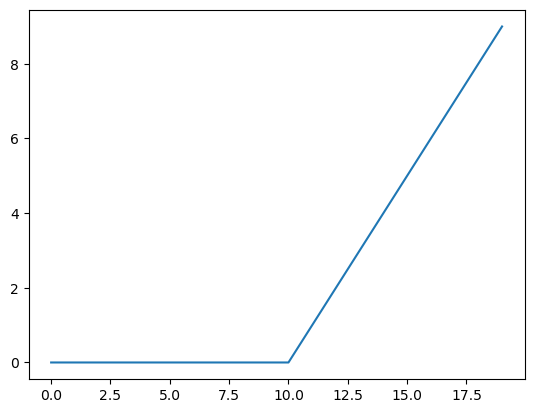

In [50]:
plt.plot(torch.relu(A));

In [51]:
def relu(x: torch.Tensor) -> torch.Tensor:
    return torch.maximum(torch.tensor(0), x) 

In [52]:
relu(A)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6., 7.,
        8., 9.])

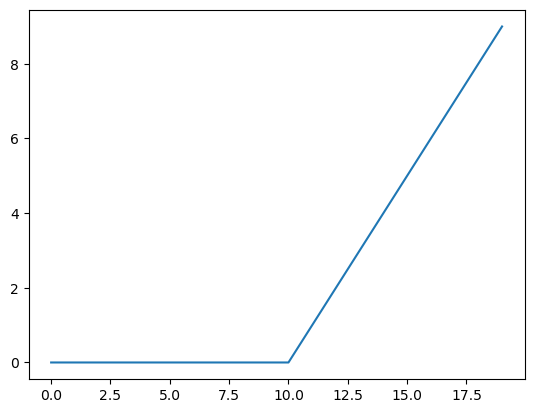

In [53]:
# Plot Relu activation function
plt.plot(relu(A));

Now let's do the same thing with sigmoid activation function: https://pytorch.org/docs/stable/generated/torch.nn.Sigmoid.html

In [54]:
def sigmoid(x: torch.Tensor) -> torch.Tensor:
    return 1 / (1 + torch.exp(-x))

In [55]:
sigmoid(A)

tensor([4.5398e-05, 1.2339e-04, 3.3535e-04, 9.1105e-04, 2.4726e-03, 6.6929e-03,
        1.7986e-02, 4.7426e-02, 1.1920e-01, 2.6894e-01, 5.0000e-01, 7.3106e-01,
        8.8080e-01, 9.5257e-01, 9.8201e-01, 9.9331e-01, 9.9753e-01, 9.9909e-01,
        9.9966e-01, 9.9988e-01])

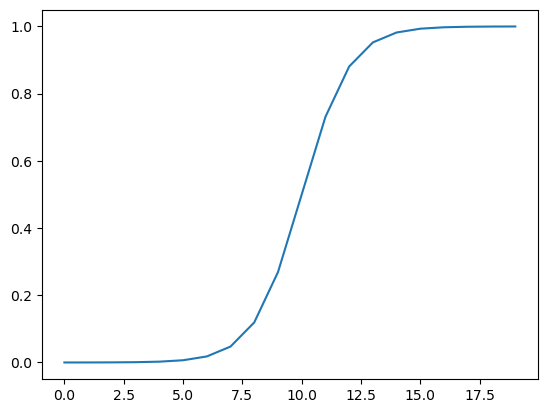

In [56]:
plt.plot(sigmoid(A));

## 8. Putting it all together with a multi-class classification problem



### 8.1 Creating a toy multi-class dataset

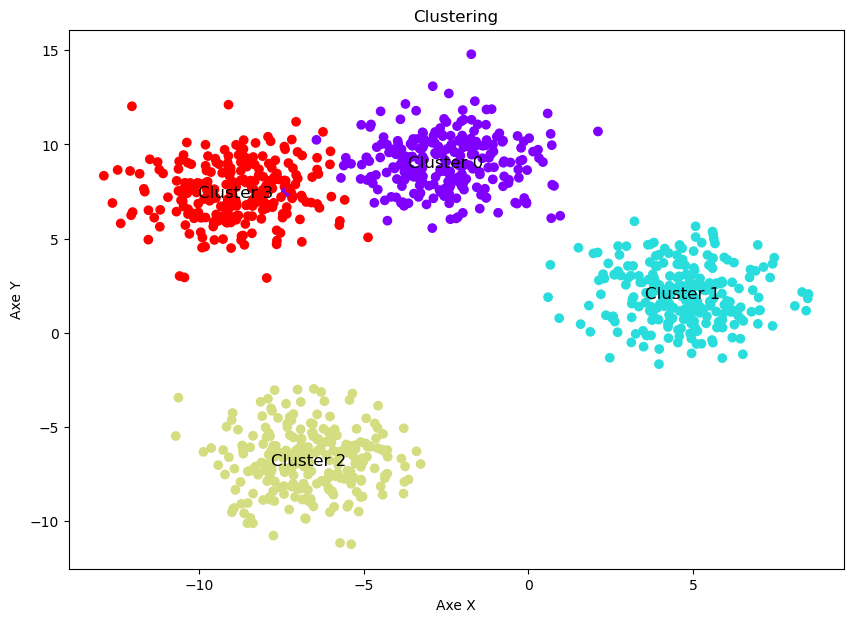

In [70]:
# Set the hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. Create multi-class data
X_Blobs, y_Blobs = make_blobs(n_samples=1000,
                              n_features=NUM_FEATURES, # input features
                              centers=NUM_CLASSES, # output classes
                              cluster_std=1.5, # give the clusters a little shake up
                              random_state=RANDOM_SEED)


# 2. Turn data into float tensors
X_blobs = torch.from_numpy(X_Blobs).type(torch.float)
y_blobs = torch.from_numpy(y_Blobs).type(torch.float)

# 2.1. Turn data into long tensors
X_blobs_long = torch.from_numpy(X_Blobs).type(torch.LongTensor)
y_blobs_long = torch.from_numpy(y_Blobs).type(torch.LongTensor)

# 3. Split float tensors into train and test sets
X_blobs_train, X_blobs_test, y_blobs_train, y_blobs_test = train_test_split(X_blobs,
                                                                            y_blobs,
                                                                            test_size=0.2,
                                                                            random_state=RANDOM_SEED)

# 3.1. Split long tensors into train and test sets
X_blobs_train_long, X_blobs_test_long, y_blobs_train_long, y_blobs_test_long = train_test_split(X_blobs_long,
                                                                                                y_blobs_long,
                                                                                                test_size=0.2,
                                                                                                random_state=RANDOM_SEED)

# 4. Plot data (visualize, visualize, visualize)
plt.figure(figsize=(10, 7))
plt.scatter(X_blobs[:, 0], X_blobs[:, 1], c=y_blobs, cmap=plt.cm.rainbow);
plt.xlabel('Axe X')
plt.ylabel('Axe Y')
plt.title('Clustering')
cluster_names = {i:f"Cluster {i}" for i in range(y_blobs.type(torch.int16).max() + 1)}
for cluster_id, cluster_name in cluster_names.items():
    cluster_points = X_blobs[y_blobs == cluster_id]
    cluster_center = cluster_points.mean(axis=0)
    plt.text(cluster_center[0], cluster_center[1], cluster_name, fontsize=12, ha="center", va="center")

### 8.2 Building a multi-class classification model with PyTorch


In [58]:
# Build a muli-class classification model
class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        '''
        Initializes multi-class classification model.

        Args:
            input_features (int): number of input features
            output_features (int): number of output features (number of output classes)
            hidden_units (int): number of hidden units per layer, default 8
        '''
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_features)
        )

    def forward(self, x):
        return self.linear_layer_stack(x)

In [59]:
# Create an instance of BlobModel and send it to the target device
model_4 = BlobModel(input_features=NUM_FEATURES,
                    output_features=NUM_CLASSES,
                    hidden_units=8).to(device)
print(model_4)

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)


### 8.3 Create a loss function and an optimizer for multi-class classification

In [60]:
# Create loss for multi-class classification
loss_fn_multiclassification = nn.CrossEntropyLoss()

# Create optimizer
optimizer_model_4 = torch.optim.SGD(model_4.parameters(), 
                                    lr=0.1)

### 8.4 Getting probabilities for multi-class PyTorch model

In [61]:
# Let's get some raw outputs of the model
model_4.eval()
with torch.inference_mode():
    y_logits = model_4(X_blobs_test.to(torch.float32))
print(y_logits[:10])

tensor([[-0.6297, -0.6848, -1.3548, -0.9882],
        [-0.0540, -0.8467, -0.4988, -0.1114],
        [ 0.2528, -0.2379,  0.1882, -0.0066],
        [-0.2966, -0.4717, -0.7388, -0.5825],
        [-0.3063, -1.3610, -1.1874, -0.3809],
        [-0.1113, -0.9762, -0.6233, -0.1410],
        [ 0.1579, -0.2858,  0.1568, -0.0075],
        [-0.2140, -1.1759, -0.9279, -0.2747],
        [ 0.2381, -0.2573,  0.1485,  0.0110],
        [-0.2244, -1.1908, -0.9713, -0.3009]])


In [62]:
# Convert logits -> prediction probabilities 
y_pred_probs = torch.softmax(y_logits, dim=1)
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[-0.6297, -0.6848, -1.3548, -0.9882],
        [-0.0540, -0.8467, -0.4988, -0.1114],
        [ 0.2528, -0.2379,  0.1882, -0.0066],
        [-0.2966, -0.4717, -0.7388, -0.5825],
        [-0.3063, -1.3610, -1.1874, -0.3809]])
tensor([[0.3196, 0.3024, 0.1548, 0.2233],
        [0.3292, 0.1490, 0.2110, 0.3108],
        [0.3011, 0.1843, 0.2823, 0.2323],
        [0.3093, 0.2596, 0.1988, 0.2324],
        [0.3716, 0.1294, 0.1540, 0.3449]])


In [63]:
# softmax function
def softmax(x: torch.tensor) -> torch.tensor:
    return torch.exp(x) / torch.exp(x).sum(dim=1, keepdim=True)

In [64]:
cluster_names

{0: 'Cluster 0', 1: 'Cluster 1', 2: 'Cluster 2', 3: 'Cluster 3'}

In [65]:
# Convert our model'spredictions probabilities into predictions labels
y_preds = torch.argmax(y_pred_probs, dim=1)
print(y_preds[:10])

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


In [71]:
# Train the model
train_test_loop(epochs=100,              
                loss_fn=loss_fn_multiclassification,
                optimizer=optimizer_model_4,
                model=model_4,
                accuracy_fn=accuracy_fn,
                X_train=X_blobs_train_long,
                y_train=y_blobs_train_long,
                X_test=X_blobs_test_long,
                y_test=y_blobs_test_long,
                multiclass=True)
                

Epoch: 0 | Loss: 0.03585, Accuracy: 99.38% | Test loss: 0.02891, Test acc: 99.50%
Epoch: 10 | Loss: 0.03413, Accuracy: 99.38% | Test loss: 0.02712, Test acc: 99.50%
Epoch: 20 | Loss: 0.03280, Accuracy: 99.38% | Test loss: 0.02570, Test acc: 99.50%
Epoch: 30 | Loss: 0.03174, Accuracy: 99.38% | Test loss: 0.02456, Test acc: 99.50%
Epoch: 40 | Loss: 0.03088, Accuracy: 99.38% | Test loss: 0.02359, Test acc: 99.00%
Epoch: 50 | Loss: 0.03017, Accuracy: 99.38% | Test loss: 0.02277, Test acc: 99.00%
Epoch: 60 | Loss: 0.02956, Accuracy: 99.38% | Test loss: 0.02207, Test acc: 99.00%
Epoch: 70 | Loss: 0.02905, Accuracy: 99.38% | Test loss: 0.02146, Test acc: 99.00%
Epoch: 80 | Loss: 0.02860, Accuracy: 99.38% | Test loss: 0.02093, Test acc: 99.00%
Epoch: 90 | Loss: 0.02820, Accuracy: 99.38% | Test loss: 0.02046, Test acc: 99.00%


### 8.6 Making and evaluating predictions with a multi-class classification model

In [74]:
# Make predictions
model_4.eval()
with torch.inference_mode():
    y_logits = model_4(X_blobs_test)

# View the 5 first predictions
print(y_logits[:5])

tensor([[ -0.9053,   8.6839,  -9.6856, -10.3120],
        [ -2.4683,  -7.6254,  -4.9325,   4.3605],
        [ -4.3683,  -4.7023,   4.1984,  -3.2677],
        [ -1.6680,   6.2593,  -5.1094,  -6.0178],
        [  5.0713,  -1.1589, -11.2232,  -8.1185]])


In [73]:
# Go from logits -> prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)
y_pred_probs[:5]

tensor([[6.8462e-05, 9.9993e-01, 1.0524e-08, 5.6256e-09],
        [1.0809e-03, 6.2242e-06, 9.1962e-05, 9.9882e-01],
        [1.9016e-04, 1.3616e-04, 9.9910e-01, 5.7162e-04],
        [3.6063e-04, 9.9962e-01, 1.1547e-05, 4.6554e-06],
        [9.9803e-01, 1.9651e-03, 8.3659e-08, 1.8659e-06]])

In [78]:
# Go from prediction probabilities -> prediction labels
y_preds = torch.argmax(y_pred_probs, dim=1)
y_preds[:5]

tensor([1, 3, 2, 1, 0])

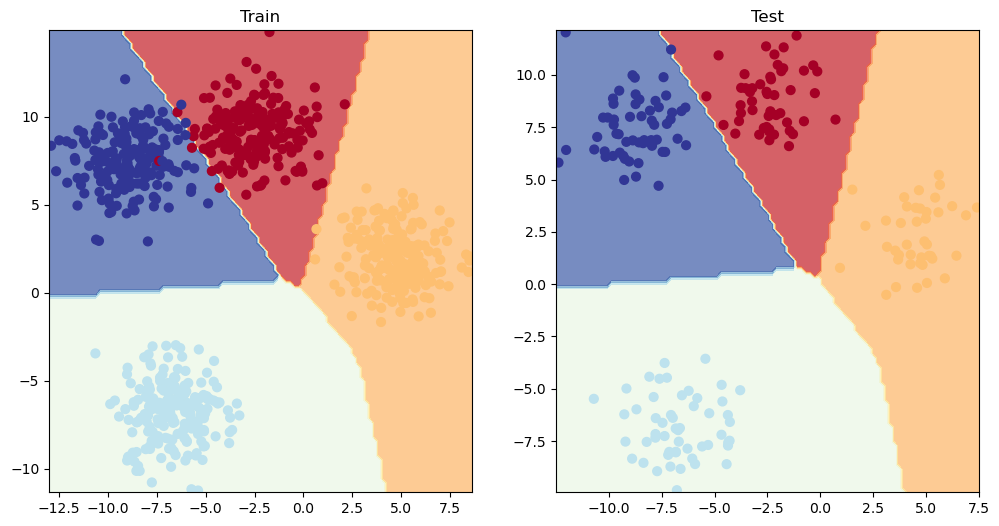

In [80]:
# Plot decision boundaries
plot_train_test_decision_boundary(model=model_4,
                                  X_train=X_blobs_train,
                                  y_train=y_blobs_train,
                                  X_test=X_blobs_test,
                                  y_test=y_blobs_test)

## 9. A few more classification metrics... (to evaluate our classification model)

* Accuracy - out of 100 samples, how many does the model predict correctly ?
* Precision - out of 100 samples that the model predicted positive, how many were actually positive ?
* Recall - out of 100 samples that the model actually positive, how many were predicted positive ?
* F1 Score - harmonic mean of precision and recall
* Confusion Matrix - number of times we predicted each class when the actual class was different
* Classification Report - precision, recall, f1-score, support for each class

See this article for when to use precision/recall: https://towardsdatascience.com/beyond-accuracy-precision-and-recall-3da06bea9f6c

If you want to access to a lot of PyTorch metrics, see TorchMetrics - https://lightning.ai/docs/torchmetrics/stable/pages/quickstart.html

In [86]:
# Setup metric
torchmetric_accuracy = Accuracy(task="multiclass", num_classes=4).to(device)

# Calculate accuracy
torchmetric_accuracy(y_preds, y_blobs_test)

tensor(0.9950)